# Tâche #3 : Classification d'incidents avec des modèles *Transformers*

Toujours avec la même tâche et les mêmes fichiers de textes, utiliser la librairie HuggingFace pour accomplir cette tâche. On demande plus spécifiquement d’utiliser le modèle bert-base-uncased et un autre modèle de votre choix.
Les consignes associées à cette tâche sont:
-	Nom du notebook : transformer.ipynb
-	Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers.
-	Plongements de mots : Ceux du modèle transformer.
-	Normalisation : Lettre en minuscule pour Bert. Aucune contrainte pour le 2e modèle.
-	Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais. Le modèle ne doit pas être une autre version de Bert et doit être significativement différent. Utilisez un 2 fichier pour ce modèle si nécessaire (une copie de celui-ci).
-	Analyse : Comparer les résultats obtenus avec les 2 modèles transformers. Présentez également une comparaison globale des résultats obtenus avec tous les modèles utilisés dans ce travail et ceux du travail précédent (TP #1).


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexe. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code.
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*dataset*)




## 1.1. Chargement des données (*dataset*)

In [ ]:
# Importation des bibliothèques nécessaires
!pip install transformers torch
!pip install transformers[torch]


import spacy
import pandas as pd
import numpy as np
import json
import torch
import transformers
import matplotlib.pyplot as plt


from torch import nn
from torch.nn.functional import softmax
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn import metrics
from torch import cuda
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from transformers import (BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Sections des configs

# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-5
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# La fonction load_dataset est utilisée pour lire le contenu des 3 fichiers (train, dev et test)
def load_dataset(filename, base_url):
    with open(base_url + '/'+ filename, 'r') as fp:
        incident_list = json.load(fp)
    return pd.DataFrame(incident_list)

In [ ]:
# Chemin d'accès aux 3 fichiers (train, dev et test)
incidents_train_fn = "incidents_train.json"
incidents_dev_fn = "incidents_dev.json"
incidents_test_fn = "incidents_test.json"
base_url = './data'

# Chargement des données
incidents_train = load_dataset(incidents_train_fn, base_url)
incidents_dev = load_dataset(incidents_dev_fn, base_url)
incidents_test = load_dataset(incidents_test_fn, base_url)

X_train, y_train = incidents_train.loc[:, "text"], incidents_train.loc[:, "label"]
X_dev, y_dev = incidents_dev.loc[:, "text"], incidents_dev.loc[:, "label"]
X_test, y_test = incidents_test.loc[:, "text"], incidents_test.loc[:, "label"]

target_incident_type = np.sort(y_train.unique().astype(int))

MAX_LEN = int(X_train.apply(len).max() / 10) # On prends

Le paramètre `max_length` de la méthode `encode_plus()` de la bibliothèque Transformers est utilisé pour spécifier la longueur maximale de la séquence d'entrée. Ce paramètre est important car le modèle de transformateur utilisé dans cet exemple exige que toutes les séquences d'entrée soient de la même longueur. Si la séquence d'entrée est plus courte que la longueur maximale spécifiée, elle sera complétée par des zéros à droite. Si la séquence d'entrée est plus longue que la longueur maximale spécifiée, elle sera tronquée à gauche.

## 1.2. Création des datasets


Pour le second modèle requis pour cette tache, nous avons choisi GPT-2, ou Generative Pre-trained Transformer 2. GPT-2 est un modèle préentraîné pour le traitement automatique du langage naturel, mais il est significativement différent de BERT en termes d'architecture.

Nous avons choisi la version DistilGPT2, ou Distilled Generative Pre-trained Transformer 2, une version plus petite du modèle GPT-2 pour la seconde partie de cette tâche pour les raisons suivantes:

- DistilGPT2 est une version distillée du modèle GPT-2
est une version distillée du modèle GPT-2. Il conserve une grande partie des performances de GPT-2 mais est plus efficace et plus rapide à entraîner, ce qui peut être avantageux lorsque les ressources sont limitées ou lorsque des itérations rapides sont nécessaires.

- En tant que variante de GPT-2, DistilGPT2 est capable de comprendre et de générer des textes de type humain, ce qui le rend adapté aux tâches qui nécessitent la compréhension d'un langage nuancé, ce qui est souvent le cas dans la classification des incidents.

- Étant donné sa nature générative, DistilGPT2 est capable de traiter différents styles de texte, qui peuvent être rencontrés dans les rapports d'incidents ou les descriptions.

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Définir le tokenizer BERT
gpt_tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2') # Définir le tokenizer GPT2

gpt_tokenizer.padding_side = "left" # default to left padding
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token # Define PAD Token = EOS Token = 50256

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Ici, on définit le tokenizer pour les modèles BERT et GPT2.

Le paramètre `padding_side` du GPT2Tokenizer est fixé à left, ce qui signifie que le padding sera ajouté à la gauche de la séquence d'entrée. Le paramètre `pad_token` a la même valeur que eos_token, ce qui signifie que le jeton de remplissage sera le même que le jeton de fin de séquence.

In [ ]:
# Définir la classe du Dataset personnalisé pour BERT
class IncidentDataset(Dataset):
    def __init__(self, text_list, labels, tokenizer, max_length):
        self.text_list = text_list
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        text = self.text_list[idx]
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, max_length=self.max_length, pad_to_max_length=True, return_token_type_ids=True, truncation=True)

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Création des jeux de données d'entraînement, de validation et de test pour BERT
bert_train_dataset = IncidentDataset(X_train, y_train.astype(int), bert_tokenizer, MAX_LEN)
bert_dev_dataset = IncidentDataset(X_dev, y_dev.astype(int), bert_tokenizer, MAX_LEN)
bert_test_dataset = IncidentDataset(X_test, y_test.astype(int), bert_tokenizer, MAX_LEN)

# Création des jeux de données d'entraînement, de validation et de test pour DistilGPT2
gpt_train_dataset = IncidentDataset(X_train, y_train.astype(int), gpt_tokenizer, MAX_LEN)
gpt_dev_dataset = IncidentDataset(X_dev, y_dev.astype(int), gpt_tokenizer, MAX_LEN)
gpt_test_dataset = IncidentDataset(X_test, y_test.astype(int), gpt_tokenizer, MAX_LEN)

## 2. Création de modèle(s)

In [ ]:
# Création du modèle personnalisé BERT
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(target_incident_type))

# Création du modèle personnalisé GPT2
gpt_model = GPT2ForSequenceClassification.from_pretrained('distilgpt2', num_labels=len(target_incident_type))
gpt_model.resize_token_embeddings(len(gpt_tokenizer))
gpt_model.config.pad_token_id = gpt_model.config.eos_token_id # fix model padding token id

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3. Entraînement de modèle(s)

In [ ]:
# Fonction pour calculer les métriques d'évaluation
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    y_pred = preds.argmax(axis=1)
    accuracy = accuracy_score(y_true=p.label_ids, y_pred=y_pred) * 100
    precision = metrics.precision_score(y_true=p.label_ids, y_pred=y_pred, average='macro') * 100
    recall = metrics.recall_score(y_true=p.label_ids, y_pred=y_pred, average='macro') * 100
    f1 = metrics.f1_score(y_true=p.label_ids, y_pred=y_pred, average='macro') * 100

    return {"precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy}

In [ ]:
# Définition des arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./bert_results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=LEARNING_RATE
)

bert_model.to(device) # Instantiate the classifier and move it to the GPU if available

# Initialisation du Trainer
bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_dev_dataset,
    compute_metrics=compute_metrics,
)

# Lancer l'entraînement
bert_training_result = bert_trainer.train()
bert_model.cpu()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score,Accuracy
1,1.454000,1.419158,32.098552,18.687485,15.482430,49.340866
2,0.697900,0.748316,45.477985,49.228031,46.752180,76.836158
3,0.507100,0.649226,59.864588,62.256200,60.530359,80.979284
4,0.500400,0.625353,71.290819,65.724880,66.201184,81.544256
5,0.251300,0.657930,85.415768,70.915076,73.772164,83.992467
6,0.370800,0.774034,81.774995,71.870764,73.552229,81.732580
7,0.099700,0.803398,82.926343,71.399736,74.223123,81.920904
8,0.577200,0.865372,82.542576,70.367048,73.607568,80.602637
9,0.095200,0.887307,81.649776,70.569566,73.219321,80.790960
10,0.069000,0.903116,81.433498,70.314138,72.984913,80.414313


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Définition des arguments d'entraînement
gpt_training_args = TrainingArguments(
    output_dir='./gpt_results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=EPOCHS+10,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=LEARNING_RATE
)

gpt_model.to(device) # Instantiate the classifier and move it to the GPU if available

# Initialisation du Trainer
gpt_trainer = Trainer(
    model=gpt_model,
    args=gpt_training_args,
    train_dataset=gpt_train_dataset,
    eval_dataset=gpt_dev_dataset,
    compute_metrics=compute_metrics,
)

# Lancer l'entraînement
gpt_training_result = gpt_trainer.train()
gpt_model.cpu()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score,Accuracy
1,1.713600,1.780758,4.394225,11.111111,6.297796,39.548023
2,1.801500,1.704861,9.987030,11.495108,7.434651,39.359699
3,1.362400,1.423856,23.167828,20.884979,18.447769,50.470810
4,1.292700,0.997069,40.409605,41.899843,39.160457,67.043315
5,0.697400,0.907379,53.465037,51.429658,49.763100,72.316384
6,0.839700,0.861459,53.203800,51.244641,51.300855,73.069680
7,0.804100,0.784481,56.263807,56.777385,55.421397,75.894539
8,0.928500,0.831217,59.631913,55.167333,55.715029,71.751412
9,0.559800,0.747193,55.543236,57.131036,55.895009,77.024482
10,0.767800,0.736661,56.239150,58.038102,56.269631,77.024482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score,Accuracy
1,1.713600,1.780758,4.394225,11.111111,6.297796,39.548023
2,1.801500,1.704861,9.987030,11.495108,7.434651,39.359699
3,1.362400,1.423856,23.167828,20.884979,18.447769,50.470810
4,1.292700,0.997069,40.409605,41.899843,39.160457,67.043315
5,0.697400,0.907379,53.465037,51.429658,49.763100,72.316384
6,0.839700,0.861459,53.203800,51.244641,51.300855,73.069680
7,0.804100,0.784481,56.263807,56.777385,55.421397,75.894539
8,0.928500,0.831217,59.631913,55.167333,55.715029,71.751412
9,0.559800,0.747193,55.543236,57.131036,55.895009,77.024482
10,0.767800,0.736661,56.239150,58.038102,56.269631,77.024482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

## 4. Évaluation et analyse de résultats

### 4.1 Modèle BERT

Le tableau ci-dessous présente l'évolution des pertes sur 10 epoch lors de l'entrainement du modèle BERT.

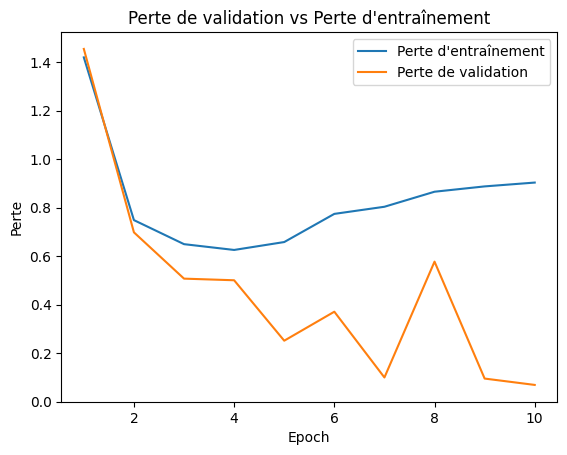

In [ ]:
history = pd.DataFrame(bert_trainer.state.log_history)

# Plot the loss values over the epochs.
plt.plot(history[history["eval_loss"].notna()]["epoch"], history[history["eval_loss"].notna()]["eval_loss"], label="Perte d'entraînement")
plt.plot(history[history["eval_loss"].notna()]["epoch"], history[(history["epoch"].isin(range(1, 11)) & history["loss"].notna() & history["eval_loss"].isna())]['loss'], label='Perte de validation')
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.title("Perte de validation vs Perte d'entraînement")
plt.legend()
plt.show()

On combinant les résultats à l'entrainement et le graphe précédent, on peut faire l'interprétation suivante des résultats :

**Perte à l'entraînement** : Elle diminue, ce qui est bon signe. Cela signifie que le modèle apprend à partir des données d'apprentissage.

**Perte de validation** : elle diminue initialement, puis augmente à partir de l'epoch 5. Cela peut indiquer que le modèle fonctionne bien, et qu'il commence à se suradapter et que la poursuite de la formation n'est peut-être pas bénéfique.

**Précision, rappel, score F1 et précision élevés** : Les valeurs élevées de précision, de rappel, de score F1 et d'exactitude sont des indicateurs positifs. Elles indiquent que le modèle est performant en termes de prédictions positives correctes, de capture des cas pertinents, et de précision globale de la classification.

Le fait que la perte de validation augmente au fil du temps alors que la perte d'entraînement diminue peut indiquer un surapprentissage. Cela signifie que le modèle apprend à bien performer sur les données d'entraînement, mais ne généralise pas aussi bien sur les données qu'il n'a jamais vues (l'ensemble de validation).

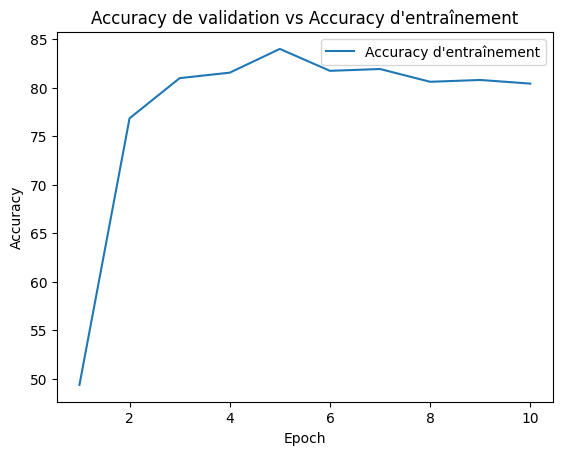

In [ ]:
plt.plot(history[history["eval_loss"].notna()]["epoch"], history[history["eval_loss"].notna()]["eval_accuracy"], label="Accuracy d'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy de validation vs Accuracy d'entraînement")
plt.legend()
plt.show()

Le fait que la perte de validation augmente au fil du temps alors que la perte d'entraînement diminue peut indiquer un surapprentissage. Cela signifie que le modèle apprend à bien performer sur les données d'entraînement, mais ne généralise pas aussi bien sur les données qu'il n'a jamais vues (l'ensemble de test). Et on constate avec l'image ci-dessus, que le modèle BERT atteint une précision de plus de 80% (81.544256) à l'epoch 4. Ces constats nous ont amenés garder très petit le nombre d'epoch pour eviter un surapprentissage.

In [ ]:
# Évaluation du modèle BERT sur les données de test
bert_model.to(device) # Instancier le classificateur et le déplacer vers le GPU s'il est disponible
bert_evaluation_results = bert_trainer.evaluate(bert_test_dataset)
bert_model.cpu()
bert_evaluation_results

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'eval_loss': 1.1991056203842163,
 'eval_precision': 69.72345731117066,
 'eval_recall': 70.84162369447469,
 'eval_f1_score': 70.07846646226866,
 'eval_accuracy': 75.51789077212806,
 'eval_runtime': 13.7786,
 'eval_samples_per_second': 38.538,
 'eval_steps_per_second': 9.653,
 'epoch': 10.0}

La cellule précédente permet d'évaluer le modèle BERT sur les données de test. Les performances du modèle sur l'ensemble de données de test sont raisonnablement bonnes. La perte d'évaluation est de 1,19, ce qui indique que le modèle se généralise bien à de nouvelles données inédites. La précision d'environ 69,72 %, le rappel de 70,84 % et le score F1 de 70.07 % suggèrent une performance équilibrée dans l'identification correcte des instances positives tout en minimisant les faux positifs. La précision (accuracy) de 75,51 % est une mesure du taux global de classification correcte. Les mesures d'évaluation sont cohérentes avec les résultats de la formation et de la validation, ce qui indique que le modèle a appris des modèles à partir des données de formation et qu'il peut raisonnablement bien se généraliser à de nouvelles instances.

### 4.2 Modèle DistilGPT2

GPT-2 est un modèle de langage génératif basé sur l'architecture Transformer. Il utilise un modèle unidirectionnel, où le contexte est construit de gauche à droite. Ici, nous allons présenter les résultat de l'entrainement fait plus haut d'une version plus petite de ce modèle: DistilGPT2

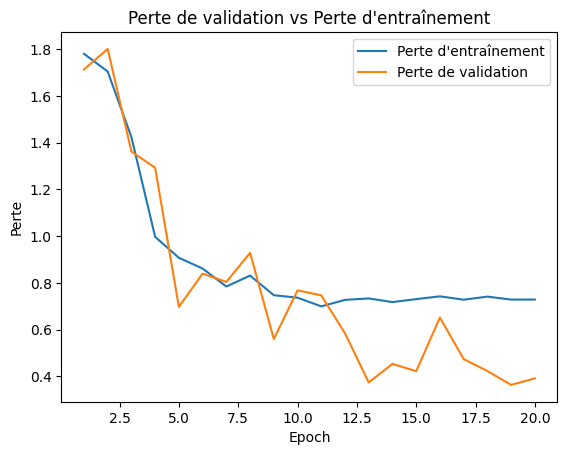

In [ ]:
gpt_history = pd.DataFrame(gpt_trainer.state.log_history)

# Plot the loss values over the epochs.
plt.plot(gpt_history[gpt_history["eval_loss"].notna()]["epoch"], gpt_history[gpt_history["eval_loss"].notna()]["eval_loss"], label="Perte d'entraînement")
plt.plot(gpt_history[gpt_history["eval_loss"].notna()]["epoch"], gpt_history[(gpt_history["epoch"].isin(range(1, 21)) & gpt_history["loss"].notna() & gpt_history["eval_loss"].isna())]['loss'], label='Perte de validation')
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.title("Perte de validation vs Perte d'entraînement")
plt.legend()
plt.show()

Le tableau ci-dessus présente l'évolution des pertes sur 10 epoch lors de l'entrainement du DistilGPT2. On peut conclure à partir des résultats à l'entrainement, les éléments suivants:

Diminution de la perte d'apprentissage : La tendance à la baisse de la perte d'apprentissage au fil des époques suggère que le modèle apprend à partir des données d'apprentissage et ajuste ses paramètres pour minimiser la différence entre les valeurs prédites et les valeurs réelles.

Diminution de la perte de validation : La diminution de la perte de validation est un signe positif, indiquant que le modèle se généralise bien à de nouvelles données inédites.

Précision, rappel, score F1 et précision : Les mesures de précision, de rappel, de score F1 et d'exactitude montrent une amélioration globale au fil des époques. Cela suggère que le modèle devient plus précis dans ses prédictions positives et dans la capture des cas pertinents.

In [ ]:
plt.plot(gpt_history[gpt_history["eval_loss"].notna()]["epoch"], gpt_history[gpt_history["eval_loss"].notna()]["eval_accuracy"], label="Perte d'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.title("Perte de validation vs Perte d'entraînement")
plt.legend()
plt.show()

Le graphe ci-dessus présente l'évolution de la précision (Accuracy) au cours des 20 epochs. La précision passe d'environ 39,55 % à la première époque à environ 79,47 % à la vingtième époque. Cette amélioration significative indique que le modèle parvient de mieux en mieux à classer correctement les cas.

In [ ]:
# Évaluation du modèle BERT
gpt_model.to(device) # Instantiate the classifier and move it to the GPU if available
gpt_evaluation_results = gpt_trainer.evaluate(gpt_test_dataset)
gpt_model.cpu()
gpt_evaluation_results

{'eval_loss': 0.8536276817321777,
 'eval_precision': 77.37740123313719,
 'eval_recall': 66.15561299921275,
 'eval_f1_score': 69.4462641698237,
 'eval_accuracy': 73.44632768361582,
 'eval_runtime': 7.4905,
 'eval_samples_per_second': 70.89,
 'eval_steps_per_second': 17.756,
 'epoch': 20.0}

Les résultats de l'évaluation sur les vraies données de test donnent un aperçu de la manière dont le modèle se généralise à de nouvelles instances. Voici une interprétation des résultats obtenues :

Perte d'évaluation : la perte d'évaluation de 0,85 est inférieure aux pertes de formation et de validation observées pendant la formation, ce qui indique que le modèle fonctionne bien sur les données de test.

Cohérence avec la formation et la validation : Les mesures d'évaluation sont cohérentes avec les résultats de la formation et de la validation, ce qui montre que le modèle se généralise bien à travers différents ensembles de données.

Dans l'ensemble, le modèle fonctionne raisonnablement bien sur les vraies données de test, avec une bonne précision, un bon rappel et un bon score F1. La précision est également satisfaisante. La perte d'évaluation est inférieure à celle observée lors de la formation, ce qui est un signe positif.

### 4.3 Comparaison des modèles BERT et DistilGPT2

En partant des résultats obtenus après l'évaluation des deux modèles sur les données de test, on peut remarquer que les deux modèles présentent des performances compétitives, avec des petites différences en termes de précision, de rappel et d'exactitude.

DistilGPT-2 a une perte d'évaluation plus faible, une précision plus élevée et un rappel légèrement plus faible que BERT.

Cependant, en se basant sur la valeur de l'accuracy, le nombre d'epoch sur lequel sont entrainés les deux modèles, on peut conclure que le modèle BERT est plus précis dans ses prédictions, dans la capture des cas pertinents et avec un temps d'entrainement beaucoup plus court.

### 4.4 Comparaison des modèles des trois tâches

Après avoir analysé les résultats pour les trois types de modèles (réseau feedforward, LSTM, et Transformers dont BERT et GPT-2), voici une analyse globale et une conclusion sur leurs performances respectives :

### Réseau Feedforward
- **Performance**:
    - Les trois variantes (Average, Max, et Min Pooling) ont montré des performances variables. La meilleure précision après l'entraînement a été obtenue avec le Average Pooling, dépassant les 60%.
    - Les courbes d'exactitude pour les différentes variantes semblent converger vers une performance similaire vers la fin des 50 époques, toutes se situant entre 35% et 45%.
    - Le modèle avec Average Pooling a démontré une performance supérieure comparée aux autres variantes.

### LSTM
- **Performance**:
    - Le modèle unidirectionnel a montré une précision d'environ 40% sur l'ensemble de test, tandis que le modèle bidirectionnel était aux alentours de 19%.
    - Ces résultats indiquent que le modèle unidirectionnel a mieux généralisé que le bidirectionnel.

### Transformers (BERT, GPT-2)
- **Performance**:
    - Le modèle BERT a démontré de bonnes performances sur l'ensemble de données de test avec une précision d'environ 69,72%, un rappel de 70,84% et un score F1 de 70,07%.
    - La précision globale était de 75,51%, indiquant une bonne généralisation à de nouvelles données.


En conclusion, le modèle Transformers (BERT) semble être le plus prometteur pour des tâches de classification complexes, avec une capacité à mieux généraliser et à équilibrer diverses mesures de performance.